# Simulation-based inference on Hodgkin-Huxley model

In this tutorial, we will infer the posterior for a Hodgkin-Huxley (HH) model through simulation-based inference. The number of spikes that a HH model produces crucially depends on the peak conductances of $g_{Na}$ and $g_{K}$.

We will infer the space of parameters $g_{Na}$ and $g_{K}$ leading to 0, 1, 2, 3, 4, or more spikes for a noisy step current input. The Hodgkin-Huxley model will be implemented in Brian, we'll train a neural density estimator in PyTorch, and finally infer the posterior.

## Requirements 

Before getting started, you will need to install brian and PyTorch. Installation depends on your operation system and package manager. See instructions given at [brian docs](https://brian2.readthedocs.io/en/stable/introduction/install.html), and [PyTorch get started](https://pytorch.org/get-started/locally/). In addition, we will use a package called [tqdm](https://github.com/tqdm/tqdm) to display progress-bars during training.

[Google Colab](https://colab.research.google.com/) and [Binder](https://mybinder.org) offer free hosted notebook solutions. If you are running this tutorial on either of those services, install packages by making a new cell in which you write and execute: `!pip install brian2 torch tqdm --user`

### Testing installation

If the installation was successful, imports in the next code cell should work out fine:

In [1]:
import brian2
import torch
import tqdm

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

print('imported brian version {}'.format(brian2.__version__))
print('imported torch version {}'.format(torch.__version__))
print('imported tqdm version {}'.format(tqdm.__version__))

imported brian version 2.2.2.1
imported torch version 1.1.0
imported tqdm version 4.32.1


## Simulating HH with two free parameters in Brian

With that in place, we create a Hodgkin-Huxley simulator in brian. The Hodgkin-Huxley model is specified through a set of differential equations. For background on the model, refer to [the original publication](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1392413/), or textbooks like [Izhikevich's](https://www.izhikevich.org/publications/dsn/index.htm) (chapter 2.3).

In the `simulate()` function below we use Brian to simulate a HH neuron model. We set the relevant fixed parameters, define the HH equations as a string, as common in Brian, and then we simulate the model for a given set of parameters. 

In our setup we have two free parameters: the peak conductances for the sodium and the potassium currents, $g_{Na}$ and $g_K$. The purpose of the function below is to simulate the HH model, given a set of parameters $(g_{Na}, g_K)$.  

To simulate efficiently, we apply a trick: Instead of running one Brian simulation for every pair of parameters we define a brian Network with many neurons, all following the HH dynamics, and without any connectivity / synapses between them. Given a set of many parameter tuples $\{(g_{Na}, g_K)\}_{i=1}^N$ we define a network with $N$ neurons, in which every neuren has different values for $(g_{Na}, g_K)$. This way we exploit the fact that Brian is optimized for network simulations and we simulate $N$ parameter tuples in parallel.

In [52]:
from brian2 import *


def simulate(params):
    """Simulate HH model for given set of parameters (params)

    Runs params.shape[0] brian HH simulations in parallel to generate voltage traces 
    and record spike times. 

    Parameters: 
        params: np.array with shape=(n_params, dim_params)
        record_traces: Boolean, flag for recording voltage traces (True) or just spike times. 

    Returns: 
        statemonitor, spikemonitor: brian statemonitor and spikemonitor if record_traces=True. 
    """
    # Parameters
    area = 20000*umetre**2 # 2*cmetre**2
    Cm = 1*ufarad*cm**-2 * area  # membrane capacitance 
    gl = 5e-5*siemens*cm**-2 * area  # leak conductance 
    
    # leak, Na, K, reversal potentials
    El = -65*mV  
    EK = -90*mV # -90
    ENa = 50*mV # 50
    VT = -63*mV  # threshold value for gating functions
    Vrefr = -40*mV  # refractory voltage
    Vthres = -40*mV  # spiking threshold #-40

    # Model equations
    eqs = Equations('''
        # Voltage
        dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm: volt
        
        # Gating variables
        dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
          (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
          (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
        dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
          (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
        dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1

        # Constant free parameters: Na conductance, K conductance and input current I
        g_na : siemens  
        g_kd : siemens
        I : amp
        ''')
    
    # Stimulus
    duration = 120 * ms  # simulation time #120
    t_on = 10 * ms  # stimulus onset 
    t_off = duration - t_on  # offset 

    # Stimulus strength
    current_strength = 1e-4*uA  #mu Ampere #ORIGINAL CODE: 1e-4

    # Noise strength
    sigma_I = 1 * current_strength

    # Trick: Network, but no connectivity
    n_neurons = params.shape[0]
    
    group = NeuronGroup(n_neurons, eqs,
                        threshold='v > Vthres',
                        refractory='v > Vrefr', 
                        method='exponential_euler')
    
    # Another trick to have noise on the input current: 
    # Change the input current every 0.1 ms: if in valid t range, use current strength plus scaled N(0, 1) noise
    group.run_regularly('I = (t_on<t) * (t<t_off) * current_strength + sigma_I * randn()', dt=0.1*ms)

    # Get the batch of (gna, gk) parameter tuples from the input 
    g_na_values = params[:, 0]
    g_kd_values = params[:, 1]

    # Set initial voltage
    group.v = El
    
    # Set different (gna, gk) values
    group.g_na = g_na_values * msiemens*cm**-2 * area
    group.g_kd = g_kd_values * msiemens*cm**-2 * area

    # Statemonitor allows to monitor traces
    statemonitor = StateMonitor(group, ['v', 'I'], record=True)
    
    # Monitor the spikes
    spikesmonitor = SpikeMonitor(group, variables = 'v', record = True)
    
    net = Network([group, statemonitor,spikesmonitor])
    net.run(duration)
    
    print('The number of spikes is ', spikesmonitor.num_spikes)

    return statemonitor

... trying it out:

The number of spikes is  2


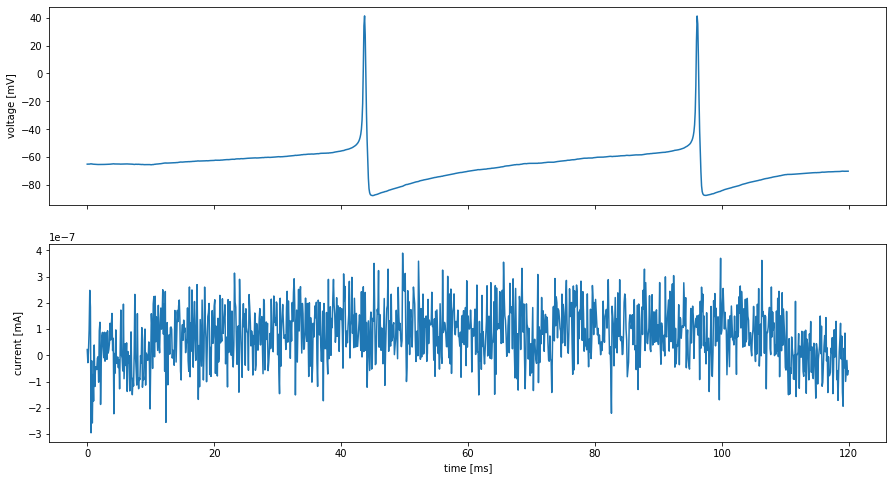

In [53]:
params = np.array([[40, 35]])
statemon = simulate(params)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
plt.sca(ax[0])
plt.plot(statemon.t/ms, statemon.v.T/mV)
plt.ylabel('voltage [mV]')
plt.sca(ax[1])
plt.plot(statemon.t/ms, statemon.I.T/mA)
plt.ylabel('current [mA]')
plt.xlabel('time [ms]')
plt.show()

### Questions

1. The above model works, but doesn't produce spikes. Can you identify a regime where it produces at least one spike by hand by playing around with the parameters manually? **We have to change Na and K conductance to the range of 5-100 $mS / cm^2$**
2. The model returns voltage and current traces. However, ultimately, we are interested in the number of spikes the model produces. Can you change the model such that it returns the spike count instead? 
Hint: You can use brian to do this, rather than writing your own function for detection.

To continue, copy the `simulate()` function from the following Gist and paste it in the cell below:

https://gist.github.com/jan-matthis/883c4a4c5b670a8ba575674b2188216d

In [54]:
def simulate(params):
    """Simulate HH model for given set of parameters (params)
    Runs params.shape[0] brian HH simulations in parallel to generate voltage traces
    and record spike times.
    Parameters:
        params: np.array with shape=(n_params, dim_params)
        record_traces: Boolean, flag for recording voltage traces (True) or just spike times.
    Returns:
        spike count
    """
    # Parameters
    area = 20000*umetre**2
    Cm = 1*ufarad*cm**-2 * area  # membrane capacitance
    gl = 5e-5*siemens*cm**-2 * area  # leak conductance
    # leak, Na, K, reversal potentials
    El = -65*mV
    EK = -90*mV
    ENa = 50*mV
    VT = -63*mV  # threshold value for gating functions
    Vrefr = -40*mV  # refractory voltage
    Vthres = -40*mV  # spiking threshold

    # Model equations
    eqs = Equations('''
        # Voltage
        dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm: volt
        # Gating variables
        dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
          (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
          (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
        dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
          (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
        dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
        # Constant free parameters: Na conductance, K conductance and input current I
        g_na : siemens
        g_kd : siemens
        I : amp
        ''')

    # Stimulus
    duration = 120 * ms  # simulation time
    t_on = 10 * ms  # stimulus onset
    t_off = duration - t_on  # offset

    # Stimulus strength
    current_strength = 1e-4*uA  #mu Ampere

    # Noise strength
    sigma_I = 1 * current_strength

    # Trick: Network, but no connectivity
    n_neurons = params.shape[0]

    group = NeuronGroup(n_neurons, eqs,
                        threshold='v > Vthres',
                        refractory='v > Vrefr',
                        method='exponential_euler')

    # Another trick to have noise on the input current:
    # Change the input current every 0.1 ms: if in valid t range, use current strength plus scaled N(0, 1) noise
    group.run_regularly('I = (t_on<t) * (t<t_off) * current_strength + sigma_I * randn()', dt=0.1*ms)

    # Get the batch of (gna, gk) parameter tuples from the input
    g_na_values = params[:, 0]
    g_kd_values = params[:, 1]

    # Set initial voltage
    group.v = El

    # Set different (gna, gk) values
    group.g_na = g_na_values * msiemens*cm**-2 * area
    group.g_kd = g_kd_values * msiemens*cm**-2 * area

    # Statemonitor allows to monitor traces
    spikemonitor = SpikeMonitor(group)

    net = Network([group, spikemonitor])
    net.run(duration)

    # Extract spike count
    counts = np.array(spikemonitor.count)

    return counts.reshape(-1, 1)

## Prior

Next, we will define a uniform prior over our parameters:
$$g_{Na} \sim Uniform[5, 120] \\ 
g_{K} \sim Uniform[1, 50]$$

In [55]:
lim_gNa = [5, 120.]
lim_gK = [1, 50.]

def prior(num_samples=10):
    gNa = np.random.uniform(lim_gNa[0], lim_gNa[1], size=(num_samples,))
    gK = np.random.uniform(lim_gK[0], lim_gK[1], size=(num_samples,))
    inputs = np.stack([gNa, gK], axis=1)
    return inputs

Calling `prior(num_samples)` will return an matrix of dimensions `(num_samples, 2)`, e.g.:

In [56]:
prior(num_samples=10)

array([[ 28.84143031,  35.97901731],
       [107.43328091,  28.7455334 ],
       [ 42.41341837,  33.95041602],
       [ 78.3580453 ,  26.70632046],
       [ 65.46618463,  18.90786667],
       [ 71.53689616,  39.11260905],
       [ 66.03411082,  15.06215801],
       [ 11.77834875,   1.56342902],
       [ 79.25677387,   4.36310919],
       [ 50.94246827,   5.7219061 ]])

We can use those parameters with the HH model:

In [57]:
s = simulate(prior(num_samples=10))

print(s)

[[2]
 [4]
 [2]
 [2]
 [2]
 [3]
 [2]
 [2]
 [2]
 [1]]


This generates a vector $s$ containing spike counts. Each of its elements $n$ is drawn from $p(s_n|g_{{Na}_n}, g_{{K}_n})$.

## Bayesian inference

We want to infer the (approximate) posteriors over spike counts, e.g., $p(g_{Na}, g_{K}|s=3)$, to answer the questions which combinations of parameters lead to exactly three spikes. By Bayes theorem, the posterior is proportional to likelihood times prior, e.g., $\mathcal{L}(\theta) = p(s=3|g_{Na}, g_{K}))$, times a uniform density. The problem is that we cannot evaluate the likelihood for the model we specified in brian above.

## Simulation-based inference by density estimation

What we can do, however, is generate samples from the model: We will generate a dataset of consisting of parameters and spike counts. We will use this dataset to train a density estimator $q(s|g_{Na}, g_{K})$. In difference to $p(s|g_{Na}, g_{K})$, we can evaluate the pdf of $q$. This will help us to infer the posterior: $q$ acts as an approximation/surrogate to the true likelihood.

There are many different kinds of density estimators. A flexible class of density estimators uses artificial neural networks (NNs). We will set up a NN in PyTorch in order to regress from input parameters $g_{Na}, g_{K}$ onto predicted number of spikes. More specifically, the regression will be onto a vector of probabilities parametrizing a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution). 

### Creating a training dataset

In [58]:
num_simulations = 1000
parameters = prior(num_samples=num_simulations)
spike_counts = simulate(parameters)

### Defining a NN in PyTorch

Below, we will set up a NN in PyTorch. To follow along, it will not be essential to know the details of how PyTorch works. If you want to read more about it, refer to the [PyTorch tutorials](https://pytorch.org/tutorials/). You can also easily find countless blog posts and video lectures online. 

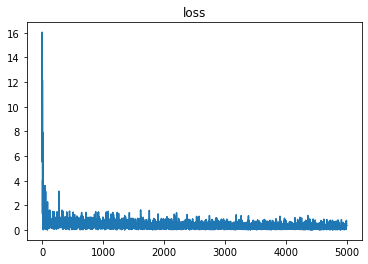

In [59]:
import torch.nn as nn

num_spikes_categories = 6
num_hiddens = [200, 200]

# The NN takes 2 parameters as input
# There are 2 hidden layers of 200 units each
# The regression is onto 6 numbers that will represent the probabilities of
# 0, 1, 2, ... 5 (or more) spikes:
network = nn.Sequential(
    nn.Linear(2, num_hiddens[0]),
    nn.ReLU(),
    nn.Linear(num_hiddens[0], num_hiddens[1]),
    nn.ReLU(),
    nn.Linear(num_hiddens[1], num_spikes_categories),
    )

# The last category represents 5 or spikes
# Therefore, we threshold spikes at 5 max:
spike_counts[spike_counts>5] = 5

# Convert the training data into a torch.tensors, and create a TensorDataset which we will use for training
# From a TensorDataset, we construct a DataLoader that allows splitting data into shuffled batches
# during training of the NN. For background see PyTorch tutorials on data handling
import torch
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(torch.tensor(parameters, dtype=torch.float32), 
                           torch.tensor(spike_counts, dtype=torch.float32))
data_loader = DataLoader(train_data, batch_size=10, shuffle=True)


# Create an optimizer
optim = torch.optim.Adam(network.parameters(), lr=0.005)


# import tqdm for progress bars
from tqdm import tqdm_notebook


# Train the parameters of the NN in minibatches
losses = []
for epoch in tqdm_notebook(range(50)):
    for inputs, outputs in data_loader:
        logits = network(inputs)
        cond_dist = torch.distributions.Categorical(logits=logits)
        loss = -1. * cond_dist.log_prob(outputs.reshape(-1)).mean()

        optim.zero_grad()
        loss.backward()
        optim.step()

        losses.append(loss.item())

# Plot loss of NN training
plt.title('loss')
plt.plot(losses)
plt.show()

Having trained the NN, we can infer the posteriors by evaluation on a grid:

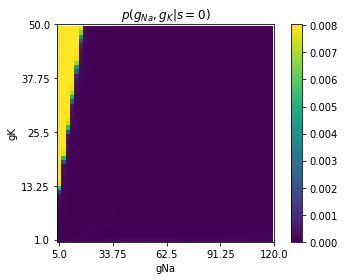

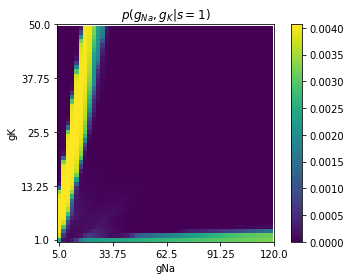

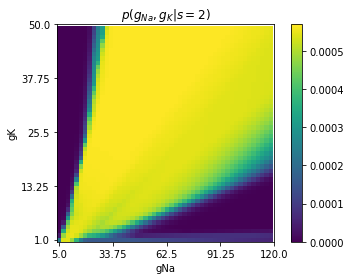

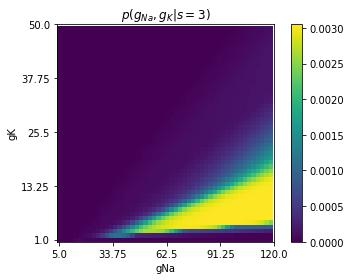

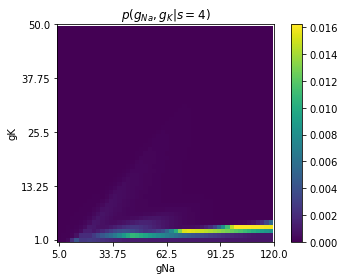

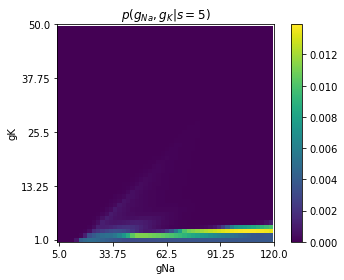

In [60]:
grid_res = 50  # resolution of grid
grid_linspaces = [np.linspace(*lim_gNa, grid_res), np.linspace(*lim_gK, grid_res)]
grids = np.stack(np.meshgrid(*grid_linspaces), axis=2)  # (grid_res, grid_res, 2)
grids_flat = grids.reshape(-1, 2)  # (grid_res**2, 2)

logits = network.forward(torch.tensor(grids_flat, dtype=torch.float32))
cond_dist = torch.distributions.Categorical(logits=logits)

probs_np = cond_dist.probs.detach().numpy().reshape(
    grid_res, grid_res, num_spikes_categories)

for num_spikes in range(num_spikes_categories):
    # probs_np contains likelihoods
    # to infer posterior probabilities, we need to multiply likelihood times prior (uniform in our example)
    # and calculate the normalizing factor Z of the posterior (the posterior pdf needs to integrate to 1):
    Z = probs_np[:, :, num_spikes] 
    Z *= grid_res/(lim_gNa[1] - lim_gNa[0]) 
    Z *= grid_res/(lim_gK[1] - lim_gK[0])
    Z = np.sum(Z)

    plt.figure()
    plt.title(r'$p(g_{Na}, g_{K}|s=' + str(num_spikes) + r')$')
    
    plt.imshow(probs_np[:,:,num_spikes]/Z, origin='lower')
    
    plt.xticks(np.linspace(0, 50, 5), np.linspace(lim_gNa[0], lim_gNa[1], 5))
    plt.xlabel('gNa')
    
    plt.yticks(np.linspace(0, 50, 5), np.linspace(lim_gK[0], lim_gK[1], 5))
    plt.ylabel('gK')
    
    plt.colorbar()
    
    plt.show()
    plt.close()

### Optional exercises:
* Pick two other parameters for which you infer the posterior: Modify simulator and priors accordingly
* Find a way to draw samples from the posterior